# Loading/Installing Prerequisites
- pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
- numpy
- pandas 
- pytorch

In [7]:
!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [8]:
!pip install opencv-contrib-python 

In [9]:
!pip install --user --upgrade numpy

In [10]:
!pip install numpy

In [11]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [12]:
import numpy as np
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [13]:
def get_table(filename):
    """[get pandas table from (un)compressed npz/npy format]

    Args:
        filename (string): [location string of the file(name)]

    Returns:
        [dataframe]: [pandas dataframe containing the numpy array(s)]
    """
    data = load(filename)
    lst = data.files
    df = pd.Dataframe()
    for item in lst:
        df[item] = data[item]
    print(df)
    return df

In [14]:
md_df = pd.read_csv("metadata.csv") # metadata.csv
print(md_df["File Location"][1])

./CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-NA-96009/1.000000-full mammogram images-63992


# Convert DICOM/PNG File into Numpy Array
Raddar. “Convert DICOM to Np.array - the Correct Way.” Kaggle, Kaggle, 30 Dec. 2020, https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way/notebook. 

In [15]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [16]:
def read_xray(path, size=299, voi_lut = False, fix_monochrome = True):
    """converts the dicom/png file into numpy array

    Args:
        path (string): path to file
        size (int, optional): [description]. Defaults to 255.
        voi_lut (bool, optional): [description]. Defaults to True.
        fix_monochrome (bool, optional): [description]. Defaults to True.

    Returns:
        [numpy array]: [numpy array containing dicom info]
    """
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * size).astype(np.uint8)
        
    return data

 Testing picture output

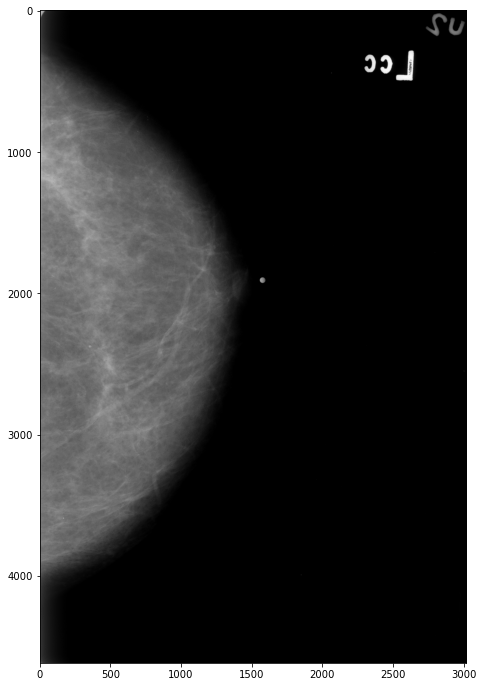

In [17]:
%matplotlib inline
img = read_xray(md_df["File Location"][1] + "/1-1.dcm")
plt.figure(figsize=(12,12))
plt.imshow(img,"gray")

In [18]:
# load calc case test set and training test
calc_test = pd.read_csv("calc_case_description_test_set.csv")
calc_train = pd.read_csv("calc_case_description_train_set.csv")

# Creating Testing and Training Sets

In [19]:
column_names = ["new id", "location","density"]
test = pd.DataFrame(columns = column_names)
train = pd.DataFrame(columns = column_names)
for index, row in md_df.iterrows():
    new_id = row['Study UID'] + '/' + row['Series UID']
    # pattern matching, finding density information
    if calc_test['image file path'].str.contains(new_id).any():
        image_file = calc_test.loc[calc_test['image file path'].str.contains(new_id)]
        df2 = {
            "new id": new_id,
            "location": row['File Location'], 
            "density": image_file[["breast density"]].values[0][0]
        }
        test = test.append(df2,ignore_index=True)
    elif calc_test['cropped image file path'].str.contains(new_id).any():
        cropped_image_file = calc_test.loc[calc_test['cropped image file path'].str.contains(new_id)]
        df2 = {
            "new id": new_id,
            "location": row['File Location'], 
            "density": cropped_image_file[["breast density"]].values[0][0]
        }
        test = test.append(df2,ignore_index=True)
    elif calc_train['image file path'].str.contains(new_id).any():
        image_file = calc_train.loc[calc_train['image file path'].str.contains(new_id)]
        df2 = {
            "new id": new_id,
            "location": row['File Location'], 
            "density": image_file[["breast density"]].values[0][0]
        }
        train = train.append(df2, ignore_index=True)
    elif calc_train['cropped image file path'].str.contains(new_id).any():
        cropped_image_file = calc_train.loc[calc_train['cropped image file path'].str.contains(new_id)]
        df2 = {
            "new id": new_id,
            "location": row['File Location'], 
            "density": cropped_image_file[["breast density"]].values[0][0]
        }
        train = train.append(df2, ignore_index=True)



In [20]:
train.head()

,new id,location,density
0,1.3.6.1.4.1.9590.100.1.2.328778919012412769218...,./CBIS-DDSM/Calc-Training_P_00005_RIGHT_CC_1/0...,3
1,1.3.6.1.4.1.9590.100.1.2.408909860712120272633...,./CBIS-DDSM/Calc-Training_P_00005_RIGHT_CC/08-...,3
2,1.3.6.1.4.1.9590.100.1.2.427517897311902339923...,./CBIS-DDSM/Calc-Training_P_00005_RIGHT_MLO/08...,3
3,1.3.6.1.4.1.9590.100.1.2.675123622103196361081...,./CBIS-DDSM/Calc-Training_P_00005_RIGHT_MLO_1/...,3
4,1.3.6.1.4.1.9590.100.1.2.241202057913673145232...,./CBIS-DDSM/Calc-Training_P_00007_LEFT_CC_1/09...,4


## Problem 1
Here we encountered a problem where the testing set is bigger than the training set, since they are all images, I decided to merge them all together, then split the new training/testing set

In [21]:
total = test.append(train, ignore_index=True)
total.head()
total.to_csv("total.csv")

## Change Density 
to transform this into a binary problem

In [22]:
new_total = total.copy()
for index, row in total.iterrows():
    if row['density'] == 1 or row['density'] == 2:
        new_total.loc[index,'density'] =  0
    elif row['density'] == 3 or row['density'] == 4:
        new_total.loc[index,'density'] = 1

new_total.head()

,new id,location,density
0,1.3.6.1.4.1.9590.100.1.2.161465562211359959230...,./CBIS-DDSM/Calc-Test_P_00038_LEFT_CC_1/08-29-...,0
1,1.3.6.1.4.1.9590.100.1.2.859354343102033567126...,./CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-20...,0
2,1.3.6.1.4.1.9590.100.1.2.384159464510350889125...,./CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-2...,0
3,1.3.6.1.4.1.9590.100.1.2.291121996131431385353...,./CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO_1/08-29...,0
4,1.3.6.1.4.1.9590.100.1.2.177706148911820252341...,./CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC/08-29-2...,0


## Spliting total datasets into test sets and training sets

In [23]:
from sklearn.model_selection import train_test_split

new_train, new_test = train_test_split(new_total, test_size=0.25, shuffle=True)

In [24]:
new_train = new_train.reset_index()
new_test = new_test.reset_index()
new_train.to_csv("train.csv")
new_test.to_csv("test.csv")

# Preparing Training and Testing Images

In [25]:
i = 0
for index, row in new_train.iterrows():
    if row['density'] == 0:
        for file in glob(row['location'] + "/" + "*.dcm"):
            array = read_xray(file)
            im = Image.fromarray(array)
            im.save("./train_set/not/" + str(i)+".jpg")
    elif row['density'] == 1:
        for file in glob(row['location'] + "/" + "*.dcm"):
            array = read_xray(file)
            im = Image.fromarray(array)
            im.save("./train_set/dense/" + str(i)+".jpg")
    i += 1

i = 0
for index, row in new_test.iterrows():
    if row['density'] == 0:
        for file in glob(row['location'] + "/" + "*.dcm"):
            array = read_xray(file)
            im = Image.fromarray(array)
            im.save("./test_set/not/" + str(i)+".jpg")
    elif row['density'] == 1:
        for file in glob(row['location'] + "/" + "*.dcm"):
            array = read_xray(file)
            im = Image.fromarray(array)
            im.save("./test_set/dense/" + str(i)+".jpg")
    i += 1

KeyboardInterrupt: 

# Creating a ResNet Architecture

In [43]:
train_data_dir = "./train_set/"
test_data_dir = "./test_set/"

class DenseOrNot(Dataset):
    def __init__(self, folder):
        dense = glob(folder+'/dense/*.jpg')
        notDense = glob(folder+'/not/*.jpg')
        self.fpaths = notDense + dense
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dense') for fpath in self.fpaths] # dog=1 & cat=0
    def __len__(self): 
        return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [53]:
data = DenseOrNot(train_data_dir)
im, label = data[100]

tensor([0.], device='cuda:0')


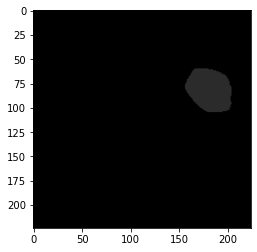

In [46]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [47]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )
def get_model():
    model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [48]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

In [51]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [50]:

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [49]:
def get_data():     
    train = DenseOrNot(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = DenseOrNot(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [52]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [54]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    print(train_losses)
    print(train_accuracies)
    print(val_accuracies)

0
[0.8381622148596722]
[0.6508152173913043]
[0.59375]
1
[0.8381622148596722, 0.6182631046875663]
[0.6508152173913043, 0.6956521739130435]
[0.59375, 0.6026785714285714]
2
[0.8381622148596722, 0.6182631046875663, 0.5767366095729496]
[0.6508152173913043, 0.6956521739130435, 0.6970108695652174]
[0.59375, 0.6026785714285714, 0.6339285714285714]
3
[0.8381622148596722, 0.6182631046875663, 0.5767366095729496, 0.5676995347375455]
[0.6508152173913043, 0.6956521739130435, 0.6970108695652174, 0.7214673913043478]
[0.59375, 0.6026785714285714, 0.6339285714285714, 0.6651785714285714]
4
[0.8381622148596722, 0.6182631046875663, 0.5767366095729496, 0.5676995347375455, 0.5492039296938025]
[0.6508152173913043, 0.6956521739130435, 0.6970108695652174, 0.7214673913043478, 0.7282608695652174]
[0.59375, 0.6026785714285714, 0.6339285714285714, 0.6651785714285714, 0.6473214285714286]


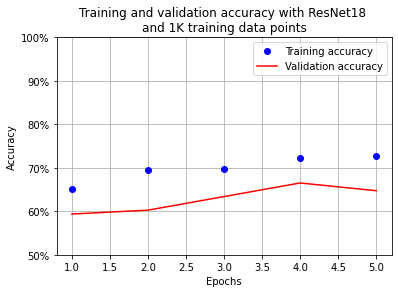

In [69]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
ticks_loc = plt.gca().get_xticks().tolist()
plt.gca().xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
ticks_loc = plt.gca().get_yticks().tolist()
plt.gca().yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks().tolist()]) 
plt.legend()
plt.grid('off')
plt.show()
